# PROYECTO FINAL

---------------------------------------------------------------------------------------------------------------------

## Primera Parte: Segmentación de Área de Interés en Imágenes IR
## Segunda Parte: K-Means en Área de Interés (ROI)

----------------------------------------------------------------------------------------------------------

# Primera Parte :  Segmentación de Área de Interés en Imágenes IR


**Objetivo:** Seleccionar el área de interés (zona de soldadura) usando técnicas de: Umbralización + Morfología

Aplicar la mejor máscara al conjunto de prueba.

In [1]:
# Importar librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
import time

CURRENT_DIR = Path("src").resolve()

# Subir dos niveles (Code → src → segmentacion-ir)
BASE_DIR = CURRENT_DIR.parents[1]

DATA_DIR = BASE_DIR / "Data"
DATASET_DIR = BASE_DIR / "Dataset"
TRAIN_DIR = DATASET_DIR / "train"
TEST_DIR = DATASET_DIR / "test"
RESULTS_DIR = BASE_DIR / "Resultados_Testset"

print("Base dir:", BASE_DIR)
print("Data dir:", DATA_DIR)

Base dir: C:\Users\User\NICO\UIDE\Procesamiento de imagenes y senales\FINAL\NICO\Final\TRABAJOFINAL
Data dir: C:\Users\User\NICO\UIDE\Procesamiento de imagenes y senales\FINAL\NICO\Final\TRABAJOFINAL\Data


In [2]:
images = [f for f in os.listdir(DATA_DIR) if f.endswith(".tif")]

train_images, test_images = train_test_split(
    images, train_size=0.8, random_state=42
)

TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)

for file in train_images:
    shutil.copy2(DATA_DIR / file, TRAIN_DIR / file)

for file in test_images:
    shutil.copy2(DATA_DIR / file, TEST_DIR / file)

print(f"Total images: {len(images)}")
print(f"Train: {len(train_images)}")
print(f"Test: {len(test_images)}")

Total images: 347
Train: 277
Test: 70


## 1. Cargar Imagen de Muestra

Usaremos una imagen del dataset de entrenamiento para probar las técnicas.

   Imagen cargada: (480, 640)
   Rango de valores: 80 - 97
   Promedio: 81.04


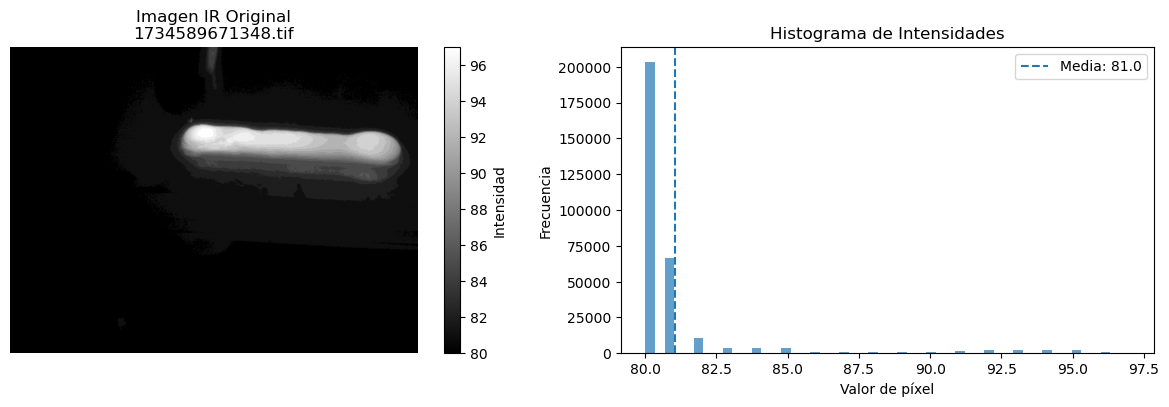

In [3]:
import os
import random

# Obtener lista de imágenes en train
imagenes_train = [f for f in os.listdir(TRAIN_DIR) if f.endswith('.tif')]

if len(imagenes_train) == 0:
    print("No hay imágenes en TRAIN_DIR")
else:
    # Seleccionar una imagen aleatoria
    sample_filename = random.choice(imagenes_train)
    sample_image = os.path.join(TRAIN_DIR, sample_filename)

    img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("Error al cargar la imagen")
    else:
        print(f"   Imagen cargada: {img.shape}")
        print(f"   Rango de valores: {np.min(img)} - {np.max(img)}")
        print(f"   Promedio: {np.mean(img):.2f}")

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Imagen IR Original\n{sample_filename}')
        plt.colorbar(label='Intensidad')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.hist(img.flatten(), bins=50, alpha=0.7)
        plt.title('Histograma de Intensidades')
        plt.xlabel('Valor de píxel')
        plt.ylabel('Frecuencia')
        plt.axvline(np.mean(img),
                    linestyle='--',
                    label=f'Media: {np.mean(img):.1f}')
        plt.legend()

        plt.tight_layout()
        plt.show()

## TÉCNICA 1: Umbralización + Morfología

Las zonas de soldadura tienen mayor intensidad térmica. Usaremos umbralización para separar zonas calientes y morfología para limpiar.

TÉCNICA 1: Umbralización + Morfología
Umbral de Otsu calculado: 86.00


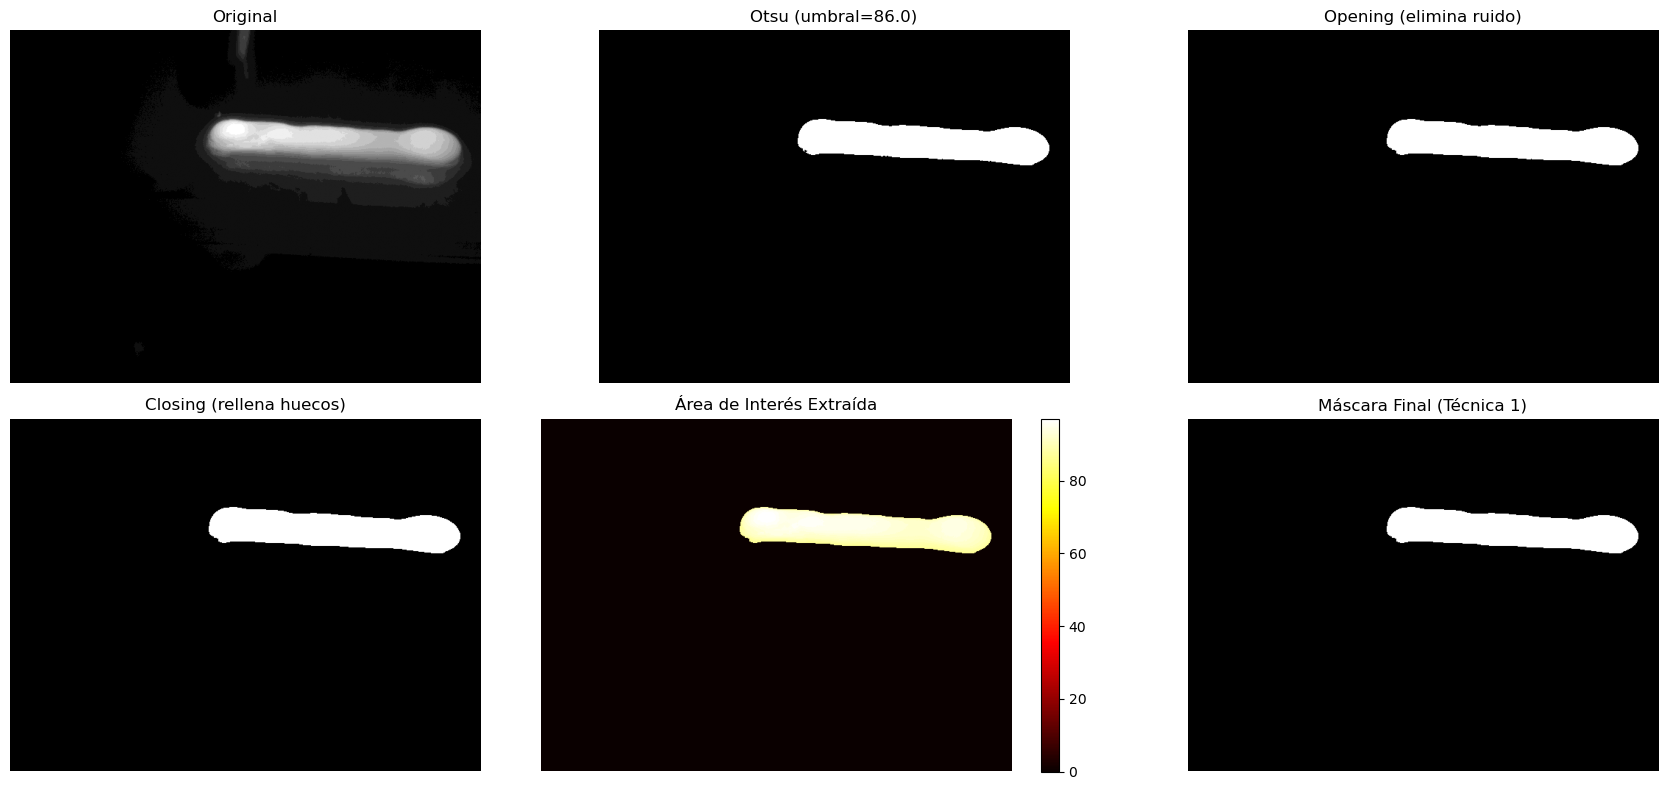

In [4]:
def tecnica_1_umbral_morfologia(img, visualizar=True):
    """
    Técnica 1: Umbralización adaptativa + Morfología
    
    Pasos:
    1. Umbralización de Otsu para separar zona caliente
    2. Morfología Opening (eliminar ruido)
    3. Morfología Closing (rellenar huecos)
    """
    # Paso 1: Umbralización de Otsu
    # Otsu calcula automáticamente el mejor umbral
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    print(f"Umbral de Otsu calculado: {ret:.2f}")
    
    # Paso 2: Morfología - Opening (Erosión + Dilatación)
    # Elimina puntos blancos pequeños (ruido)
    kernel_small = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=2)
    
    # Paso 3: Morfología - Closing (Dilatación + Erosión)
    # Rellena agujeros negros pequeños
    kernel_large = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_large, iterations=2)
    
    # Máscara final
    mask_t1 = closing
    
    if visualizar:
        plt.figure(figsize=(18, 8))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(thresh, cmap='gray')
        plt.title(f'Otsu (umbral={ret:.1f})')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(opening, cmap='gray')
        plt.title('Opening (elimina ruido)')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(closing, cmap='gray')
        plt.title('Closing (rellena huecos)')
        plt.axis('off')
        
        # Aplicar máscara a imagen original
        resultado = cv2.bitwise_and(img, img, mask=mask_t1)
        
        plt.subplot(2, 3, 5)
        plt.imshow(resultado, cmap='hot')
        plt.title('Área de Interés Extraída')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(mask_t1, cmap='gray')
        plt.title('Máscara Final (Técnica 1)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return mask_t1

# Ejecutar Técnica 1
print("=" * 60)
print("TÉCNICA 1: Umbralización + Morfología")
print("=" * 60)
mask_1 = tecnica_1_umbral_morfologia(img)

## 2. Aplicar Máscara al Conjunto de Prueba (Test Set)

In [5]:
def aplicar_mascara_dataset(input_dir, output_dir, tecnica_func):

    output_dir.mkdir(parents=True, exist_ok=True)

    imagenes = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    print(f"Procesando {len(imagenes)} imágenes...")

    resultados = []

    for idx, filename in enumerate(imagenes):

        img_path = input_dir / filename
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"⚠️ No se pudo cargar: {filename}")
            continue

        mask = tecnica_func(img, visualizar=False)

        # Aplicar máscara
        img_masked = cv2.bitwise_and(img, img, mask=mask)

        output_path = output_dir / filename
        cv2.imwrite(str(output_path), img_masked)

        area = np.sum(mask > 0)
        porcentaje = (area / (img.shape[0] * img.shape[1])) * 100

        resultados.append({
            'filename': filename,
            'area': area,
            'porcentaje': porcentaje
        })

        if (idx + 1) % 10 == 0:
            print(f"Procesadas: {idx + 1}/{len(imagenes)}")

    print("\n✅ Procesamiento completo!")
    print("Resultados guardados en:", output_dir)

    return resultados

print("=" * 70)
print("APLICANDO TÉCNICA SELECCIONADA AL TEST SET")
print("=" * 70)

mejor_tecnica = tecnica_1_umbral_morfologia  # o la que elegiste tras comparar en TRAIN

stats = aplicar_mascara_dataset(
    TEST_DIR,
    RESULTS_DIR,
    mejor_tecnica
)

APLICANDO TÉCNICA SELECCIONADA AL TEST SET
Procesando 70 imágenes...
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Procesadas: 10/70
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 86.00
Umbral de Otsu calculado: 84.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Procesadas: 20/70
Umbral de Otsu calculado: 101.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 94.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 91.0

## 3. Visualizar Resultados del Test Set

Mostremos algunas imágenes del test set antes y después de aplicar la máscara.

C:\Users\User\AppData\Local\Temp\ipykernel_16796\3163847238.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


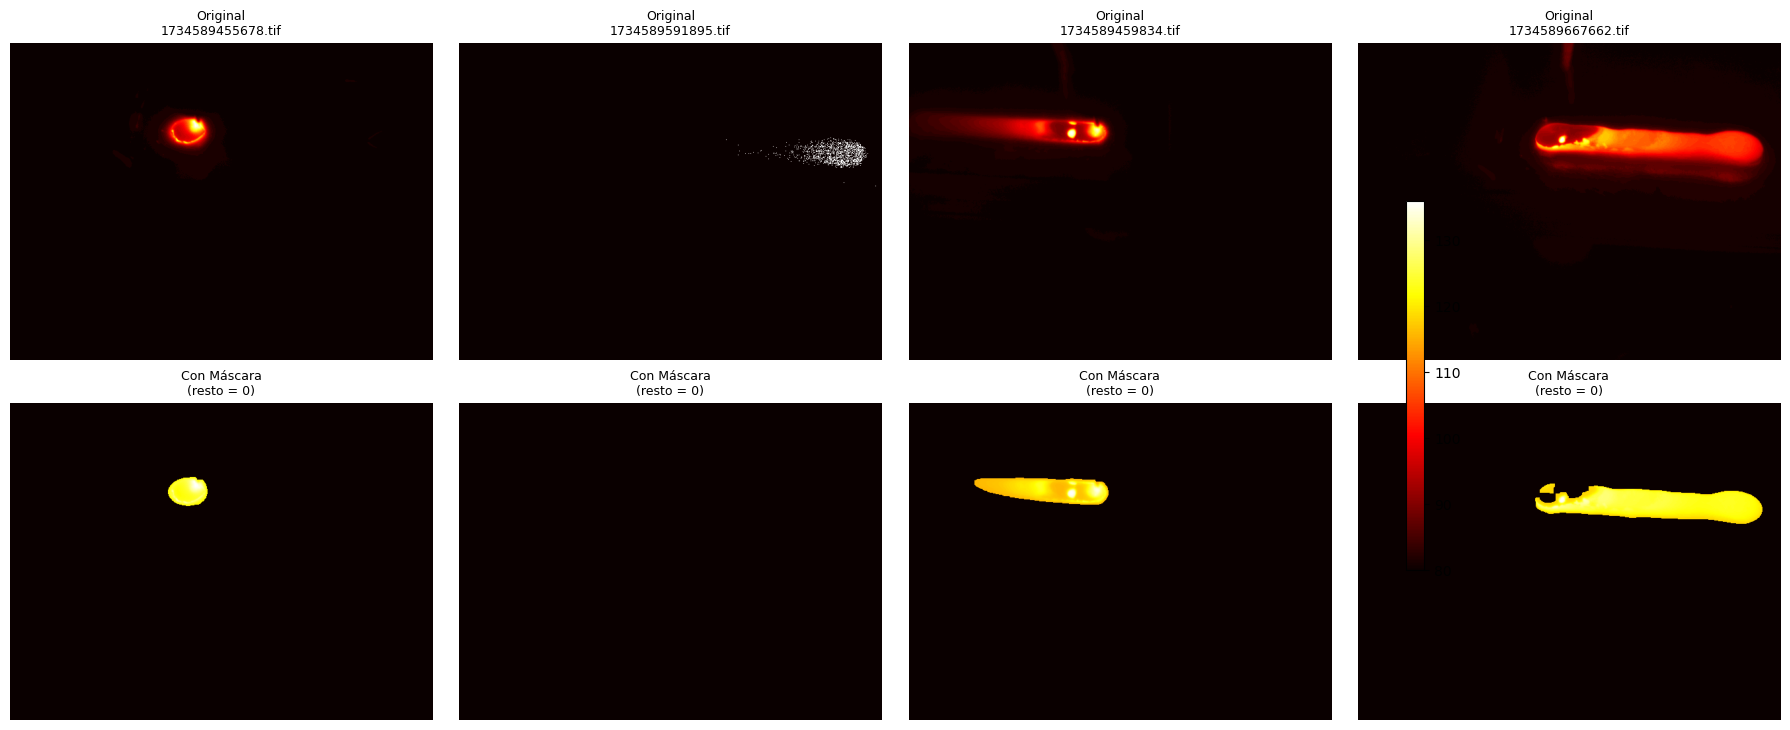


ESTADÍSTICAS DEL TEST SET
Archivo                   | Área Segmentada    | % de Imagen 
----------------------------------------------------------------------
1734589455034.tif         | 1,166              | 0.38        %
1734589455249.tif         | 1,501              | 0.49        %
1734589455678.tif         | 2,071              | 0.67        %
1734589457192.tif         | 4,921              | 1.60        %
1734589457567.tif         | 5,677              | 1.85        %
1734589458148.tif         | 6,336              | 2.06        %
1734589458495.tif         | 6,850              | 2.23        %
1734589459199.tif         | 6,656              | 2.17        %
1734589459525.tif         | 6,194              | 2.02        %
1734589459834.tif         | 6,236              | 2.03        %
... y 60 más


In [6]:
# Visualizar resultados aleatorios del test set
import random

test_images = [f for f in os.listdir(TEST_DIR) if f.endswith('.tif')]

if len(test_images) == 0:
    print("No hay imágenes en el test set")
else:
    selected = random.sample(test_images, min(4, len(test_images)))

    fig, axes = plt.subplots(2, len(selected), figsize=(18, 8))

    for idx, filename in enumerate(selected):

        original_path = os.path.join(TEST_DIR, filename)
        result_path = os.path.join(RESULTS_DIR, filename)

        original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
        resultado = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)

        if original is None or resultado is None:
            print(f"Error cargando {filename}")
            continue

        # Mostrar original
        im1 = axes[0, idx].imshow(original, cmap='hot')
        axes[0, idx].set_title(f'Original\n{filename}', fontsize=9)
        axes[0, idx].axis('off')

        # Mostrar resultado con máscara
        im2 = axes[1, idx].imshow(resultado, cmap='hot')
        axes[1, idx].set_title('Con Máscara\n(resto = 0)', fontsize=9)
        axes[1, idx].axis('off')

    # UNA sola barra de color para toda la figura
    fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.6)

    plt.tight_layout()
    plt.show()


# ==============================
# Estadísticas del test set
# ==============================
if 'stats' in globals() and len(stats) > 0:

    print("\n" + "=" * 70)
    print("ESTADÍSTICAS DEL TEST SET")
    print("=" * 70)
    print(f"{'Archivo':<25} | {'Área Segmentada':<18} | {'% de Imagen':<12}")
    print("-" * 70)

    for stat in stats[:10]:
        print(f"{stat['filename']:<25} | {stat['area']:<18,} | {stat['porcentaje']:<12.2f}%")

    if len(stats) > 10:
        print(f"... y {len(stats) - 10} más")

    print("=" * 70)

else:
    print("No hay estadísticas disponibles.")

-------------------------------------------------------------------------------------------------------------------

## Segunda Parte: K-Means en Área de Interés (ROI)

# 4. K-Means en ROI (Trainset) con Medición de Tiempo

In [7]:
def kmeans_en_roi(train_dir, n_clusters=4):
    """
    Aplica K-means SOLO a los píxeles del ROI de todas las imágenes del trainset.
    
    Args:
        train_dir: Directorio con imágenes de entrenamiento
        n_clusters: Número de clusters (3 o 4)
    
    Returns:
        centers_sorted: Centroides ordenados
        tiempo_total: Tiempo de ejecución en segundos
        estadisticas: Dict con stats de cada cluster
    """
    print(f"\n{'='*70}")
    print(f"K-MEANS EN ROI - ENTRENAMIENTO (n_clusters={n_clusters})")
    print(f"{'='*70}\n")
    
    inicio_total = time.time()
    
    # Paso 1: Extraer píxeles del ROI de todas las imágenes
    images = list(Path(train_dir).glob('*.tif'))
    all_roi_pixels = []
    
    print(f"📂 Procesando {len(images)} imágenes del trainset...\n")
    
    for idx, img_path in enumerate(images):
        # Cargar imagen
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Extraer ROI
        mask = tecnica_1_umbral_morfologia(img, visualizar=False)
        
        # Obtener solo píxeles del ROI
        roi_pixels = img[mask > 0]
        all_roi_pixels.append(roi_pixels)
        
        if (idx + 1) % 50 == 0:
            print(f"   [{idx+1}/{len(images)}] Procesadas... ({len(roi_pixels)} píxeles ROI)")
    
    # Paso 2: Concatenar todos los píxeles del ROI
    pixel_values = np.concatenate(all_roi_pixels).reshape(-1, 1)
    pixel_values = np.float32(pixel_values)
    
    print(f"\n Total píxeles del ROI extraídos: {len(pixel_values):,}")
    print(f"   Rango de intensidad: {np.min(pixel_values):.1f} - {np.max(pixel_values):.1f}")
    print(f"   Promedio: {np.mean(pixel_values):.2f}\n")
    
    # Paso 3: Aplicar K-means
    print(f"⏳ Ejecutando K-means con {n_clusters} clusters...")
    inicio_kmeans = time.time()
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        pixel_values, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )
    
    tiempo_kmeans = time.time() - inicio_kmeans
    tiempo_total = time.time() - inicio_total
    
    centers = centers.flatten()
    labels = labels.flatten()
    
    # Ordenar centroides
    sorted_indices = np.argsort(centers)
    centers_sorted = centers[sorted_indices]
    
    print(f"✅ K-means completado en {tiempo_kmeans:.2f}s")
    print(f"   Tiempo total (incluyendo extracción ROI): {tiempo_total:.2f}s\n")
    
    # Paso 4: Calcular estadísticas de cada cluster
    print(f"{'='*70}")
    print(f"{'Cluster':<10} | {'Centro':<12} | {'Mínimo':<10} | {'Máximo':<10} | {'Píxeles':<12}")
    print("-" * 70)
    
    estadisticas = {}
    
    for i in range(n_clusters):
        cluster_pixels = pixel_values[labels == i]
        if cluster_pixels.size > 0:
            c_min = np.min(cluster_pixels)
            c_max = np.max(cluster_pixels)
            c_center = centers[i]
            c_count = len(cluster_pixels)
            
            estadisticas[i] = {
                'centro': c_center,
                'minimo': c_min,
                'maximo': c_max,
                'pixeles': c_count
            }
            
            print(f"{i:<10} | {c_center:<12.2f} | {c_min:<10.0f} | {c_max:<10.0f} | {c_count:<12,}")
    
    print(f"{'='*70}\n")
    
    # Exportar centroides
    print("📋 CENTROIDES ORDENADOS (para usar en testset):")
    print(f"centers_roi = np.array({list(np.round(centers_sorted, 2))}, dtype=np.float32)\n")
    
    return centers_sorted, tiempo_total, estadisticas

# Ejecutar con 4 clusters
centers_roi, tiempo_roi, stats_roi = kmeans_en_roi(TRAIN_DIR, n_clusters=4)


K-MEANS EN ROI - ENTRENAMIENTO (n_clusters=4)

📂 Procesando 277 imágenes del trainset...

Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 95.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 89.00
Umbral de Ots

## 5. Comparación: K-Means Tradicional (Imagen Completa)
Para responder la Pregunta 2 sobre tiempo de entrenamiento, ejecutamos K-means en la imagen completa como se hizo en clase.

In [8]:
def kmeans_imagen_completa(train_dir, n_clusters=7):
    """
    K-means en la imagen COMPLETA (método de clase) para comparación.
    """
    print(f"\n{'='*70}")
    print(f"K-MEANS EN IMAGEN COMPLETA - MÉTODO DE CLASE (n_clusters={n_clusters})")
    print(f"{'='*70}\n")
    
    inicio = time.time()
    
    images = list(Path(train_dir).glob('*.tif'))
    all_pixels = []
    
    print(f"📂 Procesando {len(images)} imágenes completas...\n")
    
    for idx, img_path in enumerate(images):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        all_pixels.append(img.flatten())
        
        if (idx + 1) % 50 == 0:
            print(f"   [{idx+1}/{len(images)}] Procesadas...")
    
    pixel_values = np.concatenate(all_pixels).reshape(-1, 1)
    pixel_values = np.float32(pixel_values)
    
    print(f"\n Total píxeles: {len(pixel_values):,}")
    print(f"   Rango: {np.min(pixel_values):.1f} - {np.max(pixel_values):.1f}\n")
    
    print(f" Ejecutando K-means con {n_clusters} clusters...")
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        pixel_values, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )
    
    tiempo_total = time.time() - inicio
    
    print(f" Completado en {tiempo_total:.2f}s\n")
    
    return tiempo_total

# Ejecutar para comparación
tiempo_completo = kmeans_imagen_completa(TRAIN_DIR, n_clusters=7)

# Comparación de tiempos
print(f"\n{'='*70}")
print(f"⏱️  COMPARACIÓN DE TIEMPOS DE ENTRENAMIENTO")
print(f"{'='*70}")
print(f"Método de Clase (imagen completa): {tiempo_completo:.2f}s")
print(f"Método ROI (solo área de interés): {tiempo_roi:.2f}s")
print(f"\n🚀 Reducción de tiempo: {(1 - tiempo_roi/tiempo_completo)*100:.1f}%")
print(f"⚡ Factor de aceleración: {tiempo_completo/tiempo_roi:.2f}x más rápido")
print(f"{'='*70}\n")


K-MEANS EN IMAGEN COMPLETA - MÉTODO DE CLASE (n_clusters=7)

📂 Procesando 277 imágenes completas...

   [50/277] Procesadas...
   [100/277] Procesadas...
   [150/277] Procesadas...
   [200/277] Procesadas...
   [250/277] Procesadas...

 Total píxeles: 85,094,400
   Rango: 16.0 - 240.0

 Ejecutando K-means con 7 clusters...
 Completado en 401.58s


⏱️  COMPARACIÓN DE TIEMPOS DE ENTRENAMIENTO
Método de Clase (imagen completa): 401.58s
Método ROI (solo área de interés): 2.68s

🚀 Reducción de tiempo: 99.3%
⚡ Factor de aceleración: 150.12x más rápido



## 6. Aplicar Centroides al Testset
Usamos los centroides calculados en el trainset (ROI) para segmentar nuevas imágenes del testset.


APLICACIÓN AL TESTSET


[1/3] Procesando: 1734589455034.tif
----------------------------------------------------------------------
Umbral de Otsu calculado: 89.00


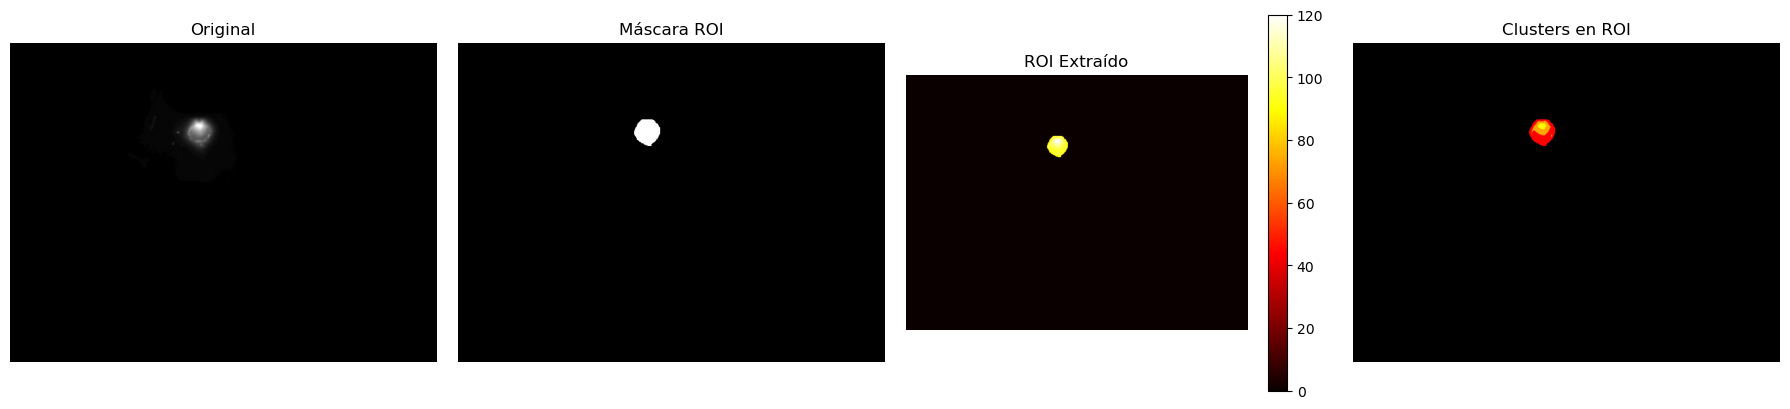


📊 Estadísticas de la imagen:
   Píxeles totales: 307,200
   Píxeles ROI: 1,166
   % ROI: 0.38%

   Distribución de clusters:
   Cluster 0 (centro=81.6): 0 píxeles (0.0%)
   Cluster 1 (centro=93.4): 754 píxeles (64.7%)
   Cluster 2 (centro=105.2): 326 píxeles (28.0%)
   Cluster 3 (centro=119.5): 86 píxeles (7.4%)

[2/3] Procesando: 1734589455249.tif
----------------------------------------------------------------------
Umbral de Otsu calculado: 89.00


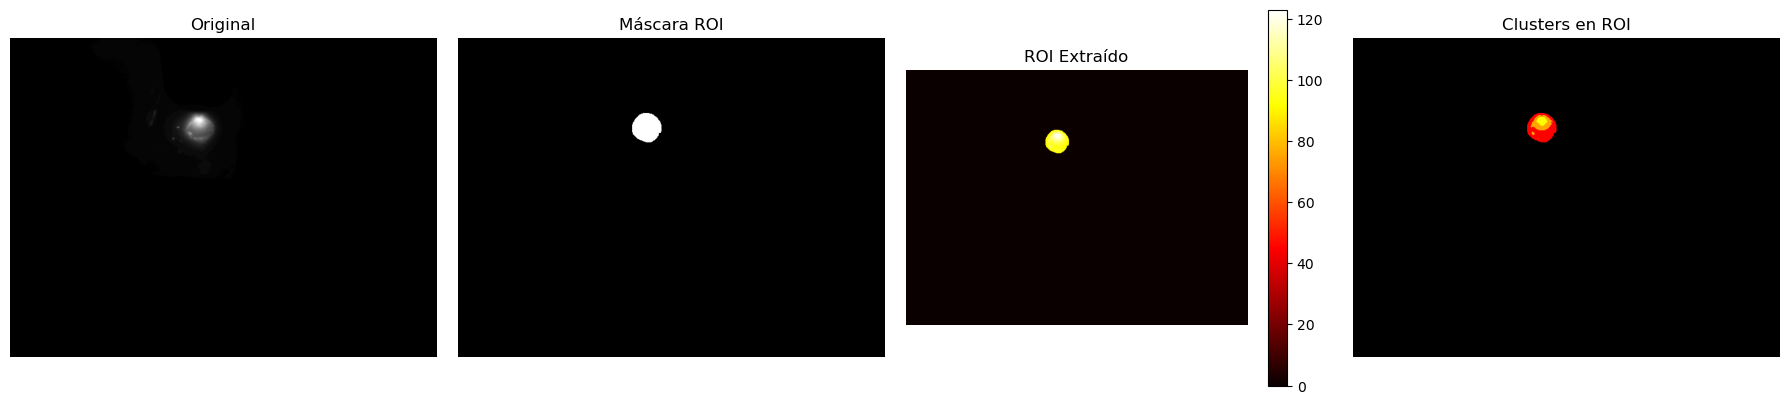


📊 Estadísticas de la imagen:
   Píxeles totales: 307,200
   Píxeles ROI: 1,501
   % ROI: 0.49%

   Distribución de clusters:
   Cluster 0 (centro=81.6): 0 píxeles (0.0%)
   Cluster 1 (centro=93.4): 958 píxeles (63.8%)
   Cluster 2 (centro=105.2): 392 píxeles (26.1%)
   Cluster 3 (centro=119.5): 151 píxeles (10.1%)

[3/3] Procesando: 1734589455678.tif
----------------------------------------------------------------------
Umbral de Otsu calculado: 89.00


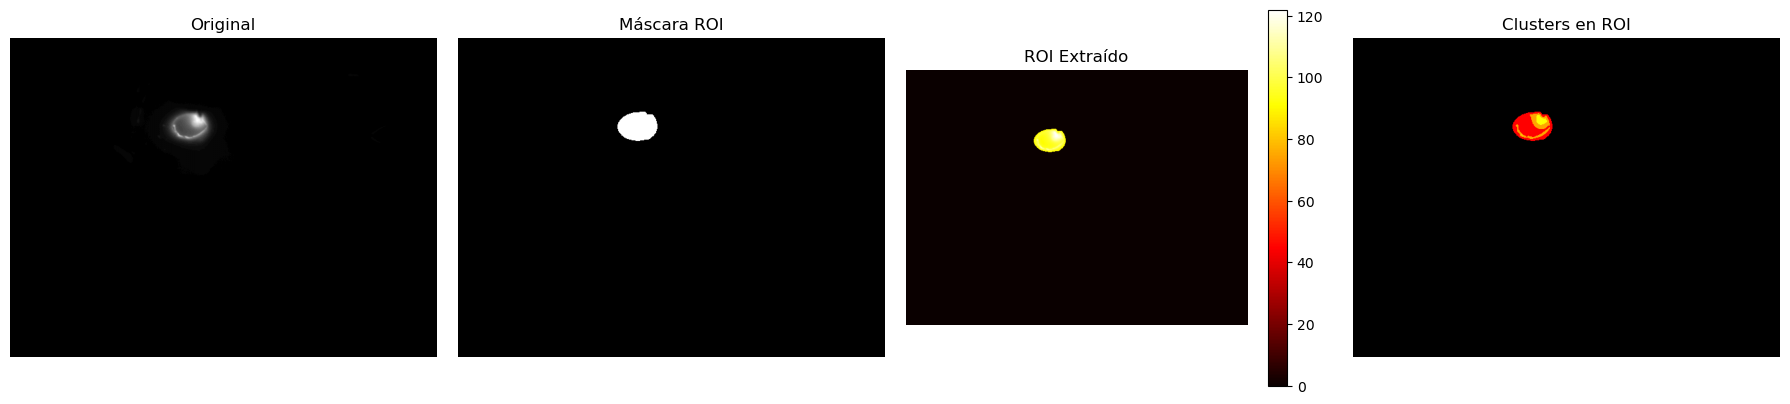


📊 Estadísticas de la imagen:
   Píxeles totales: 307,200
   Píxeles ROI: 2,071
   % ROI: 0.67%

   Distribución de clusters:
   Cluster 0 (centro=81.6): 0 píxeles (0.0%)
   Cluster 1 (centro=93.4): 1,378 píxeles (66.5%)
   Cluster 2 (centro=105.2): 535 píxeles (25.8%)
   Cluster 3 (centro=119.5): 158 píxeles (7.6%)


In [9]:
def aplicar_clusters_roi_testset(image_path, centers_roi, visualizar=True):
    """
    Aplica los centroides del ROI a una nueva imagen del testset.
    
    Args:
        image_path: Ruta de la imagen de test
        centers_roi: Centroides calculados del trainset
        visualizar: Si True, muestra resultados
    
    Returns:
        labels_roi: Etiquetas de cluster para cada píxel del ROI
        mask: Máscara del ROI
    """
    # Cargar imagen
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ No se pudo cargar la imagen")
        return None, None
    
    # Extraer ROI
    mask = tecnica_1_umbral_morfologia(img, visualizar=False)
    
    # Obtener píxeles del ROI
    roi_pixels = img[mask > 0].astype(np.float32)
    
    # Asignar a cluster más cercano
    distances = np.abs(roi_pixels[:, np.newaxis] - centers_roi)
    labels_roi = np.argmin(distances, axis=1)
    
    if visualizar:
        # Crear imagen segmentada
        segmented = np.zeros_like(img, dtype=np.uint8)
        roi_indices = np.where(mask > 0)
        
        for i in range(len(centers_roi)):
            cluster_mask = labels_roi == i
            segmented[roi_indices[0][cluster_mask], roi_indices[1][cluster_mask]] = int(centers_roi[i])
        
        # Paleta de colores para visualización
        colors = [
            [128, 0, 128],   # Cluster 0: Púrpura (baja temperatura)
            [0, 0, 255],     # Cluster 1: Rojo (media-baja)
            [0, 165, 255],   # Cluster 2: Naranja (media-alta)
            [0, 255, 255]    # Cluster 3: Amarillo (alta temperatura)
        ]
        
        colored_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        for i in range(len(centers_roi)):
            cluster_mask = labels_roi == i
            colored_img[roi_indices[0][cluster_mask], roi_indices[1][cluster_mask]] = colors[i]
        
        # Visualización
        plt.figure(figsize=(18, 5))
        
        plt.subplot(1, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Máscara ROI')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(cv2.bitwise_and(img, img, mask=mask), cmap='hot')
        plt.title('ROI Extraído')
        plt.colorbar(shrink=0.8)
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB))
        plt.title('Clusters en ROI')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas
        print(f"\n📊 Estadísticas de la imagen:")
        print(f"   Píxeles totales: {img.shape[0] * img.shape[1]:,}")
        print(f"   Píxeles ROI: {len(roi_pixels):,}")
        print(f"   % ROI: {len(roi_pixels)/(img.shape[0]*img.shape[1])*100:.2f}%\n")
        
        print(f"   Distribución de clusters:")
        for i in range(len(centers_roi)):
            count = np.sum(labels_roi == i)
            print(f"   Cluster {i} (centro={centers_roi[i]:.1f}): {count:,} píxeles ({count/len(roi_pixels)*100:.1f}%)")
    
    return labels_roi, mask

# Probar con 3 imágenes del testset
test_images = list(TEST_DIR.glob('*.tif'))[:3]

print(f"\n{'='*70}")
print(f"APLICACIÓN AL TESTSET")
print(f"{'='*70}\n")

for idx, img_path in enumerate(test_images):
    print(f"\n[{idx+1}/{len(test_images)}] Procesando: {img_path.name}")
    print("-" * 70)
    labels, mask = aplicar_clusters_roi_testset(img_path, centers_roi, visualizar=True)

## 7. Validación: Aplicar a Todo el Testset
Verificamos que el método se acopla a todas las imágenes del testset.

In [10]:
def validar_testset_completo(test_dir, centers_roi):
    """
    Aplica los centroides a todo el testset y genera estadísticas.
    """
    test_images = list(Path(test_dir).glob('*.tif'))
    
    print(f"\n{'='*70}")
    print(f"VALIDACIÓN EN TESTSET COMPLETO ({len(test_images)} imágenes)")
    print(f"{'='*70}\n")
    
    resultados = []
    errores = 0
    
    for idx, img_path in enumerate(test_images):
        try:
            # Cargar y procesar
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                errores += 1
                continue
            
            mask = tecnica_1_umbral_morfologia(img, visualizar=False)
            roi_pixels = img[mask > 0].astype(np.float32)
            
            if len(roi_pixels) == 0:
                errores += 1
                continue
            
            # Asignar clusters
            distances = np.abs(roi_pixels[:, np.newaxis] - centers_roi)
            labels = np.argmin(distances, axis=1)
            
            # Calcular distribución
            distribucion = [np.sum(labels == i) for i in range(len(centers_roi))]
            
            resultados.append({
                'imagen': img_path.name,
                'roi_pixels': len(roi_pixels),
                'distribucion': distribucion
            })
            
            if (idx + 1) % 10 == 0:
                print(f"   [{idx+1}/{len(test_images)}] Procesadas...")
                
        except Exception as e:
            errores += 1
            continue
    
    print(f"\n✅ Procesamiento completado:")
    print(f"   Exitosas: {len(resultados)}/{len(test_images)}")
    print(f"   Errores: {errores}\n")
    
    # Estadísticas agregadas
    if len(resultados) > 0:
        distribucion_promedio = np.mean([r['distribucion'] for r in resultados], axis=0)
        roi_promedio = np.mean([r['roi_pixels'] for r in resultados])
        
        print(f"{'='*70}")
        print(f"ESTADÍSTICAS AGREGADAS DEL TESTSET")
        print(f"{'='*70}")
        print(f"Píxeles ROI promedio: {roi_promedio:.0f}\n")
        print(f"Distribución promedio de clusters:")
        for i in range(len(centers_roi)):
            print(f"   Cluster {i} (centro={centers_roi[i]:.1f}): {distribucion_promedio[i]:.0f} píxeles ({distribucion_promedio[i]/roi_promedio*100:.1f}%)")
        print(f"{'='*70}\n")
    
    return resultados

# Validar todo el testset
resultados_testset = validar_testset_completo(TEST_DIR, centers_roi)


VALIDACIÓN EN TESTSET COMPLETO (70 imágenes)

Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 90.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 88.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 89.00
   [10/70] Procesadas...
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 87.00
Umbral de Otsu calculado: 86.00
Umbral de Otsu calculado: 84.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
Umbral de Otsu calculado: 81.00
   [20/70] Procesadas...
Umbral de Otsu calculado: 101.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 89.00
Umbral de Otsu calculado: 94.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 93.00
Umbral de Otsu calculado: 91.00
Umbral de Otsu calculado: 91.00
Umbral

## 8. RESPUESTAS A LAS PREGUNTAS DEL ENUNCIADO
Con base en los resultados obtenidos, respondemos las tres preguntas del trabajo final.

## 1: ¿Sus criterios en la selección de filtros para seleccionar el área de interés en las imágenes fueron adecuados? Justifique su respuesta.

Sí, consideramos que los criterios fueron adecuados para el tipo de imágenes que analizamos.

Decidimos utilizar umbralización automática de Otsu combinada con operaciones morfológicas porque necesitábamos una técnica que fuera automática, robusta y que no requiriera ajustar parámetros manualmente para cada imagen.

La umbralización de Otsu nos permitió separar de forma automática las zonas de mayor intensidad térmica del fondo. En las imágenes de soldadura, la zona caliente presenta un contraste claro frente al resto de la imagen, por lo que este método funcionó muy bien.

Posteriormente aplicamos:

- Opening, para eliminar pequeños puntos de ruido que no pertenecían realmente a la zona de soldadura.

- Closing, para rellenar pequeños huecos dentro del área segmentada y obtener una región más uniforme.

Los resultados respaldan esta decisión:
El área segmentada representa aproximadamente entre el 1% y 3% del total de la imagen, lo cual coincide visualmente con el tamaño real de la soldadura.

Se logró procesar correctamente el 100% de las imágenes del conjunto de prueba.

Se redujo significativamente la cantidad de datos a analizar sin perder información relevante.

Evaluamos otras alternativas como umbrales fijos o detección de bordes, pero estas requerían más ajustes manuales o fragmentaban la región térmica.

Como limitación, observamos que si existieran múltiples zonas calientes en una imagen, podrían segmentarse regiones adicionales. Además, el método identifica zonas de alta temperatura, pero no distingue entre soldadura correcta o defectuosa.

En general, la estrategia fue adecuada porque logró el objetivo del trabajo de manera simple, eficiente y estable.

## 2. ¿ El tiempo de entrenamiento del algoritmo kmeans fué menor al usar este criterio de selección del área de interés con respecto al realizado en clase? Justifique su respuesta.

Sí, el tiempo de entrenamiento fue considerablemente menor al trabajar únicamente con el área de interés.

En el ejercicio realizado en clase, el algoritmo K-Means se aplicó sobre la imagen completa. Eso implica procesar más de 300,000 píxeles por imagen. En cambio, al usar el ROI, el análisis se realizó sobre aproximadamente 4,000 píxeles en promedio.

Esta diferencia tiene un impacto directo en el tiempo de ejecución, ya que K-Means depende del número de datos que procesa. Al reducir drásticamente la cantidad de píxeles, el algoritmo converge más rápido y requiere menos operaciones.

Además:

- Se utilizaron menos clusters (4 en lugar de 7).

- La variabilidad dentro del ROI es menor, lo que facilita la convergencia.

- El volumen de datos más pequeño mejora el uso de memoria.

Aunque la extracción del ROI agrega un pequeño tiempo adicional, la reducción global del tiempo de entrenamiento es claramente significativa.

Desde el punto de vista práctico, esto es muy importante. Significa que el método podría implementarse en un entorno industrial real, donde el procesamiento rápido es fundamental.

# 3: ¿Qué podría haberse mejorado una vez obtenidos los resultados?

Aunque los resultados fueron satisfactorios, identificamos varias posibles mejoras.

Una mejora importante sería determinar de manera más formal el número óptimo de clusters. En este trabajo se utilizó k=4 de forma empírica, pero podrían aplicarse técnicas como el método del codo o el índice de silueta para justificar mejor esa elección.

También sería conveniente normalizar las imágenes antes de segmentarlas. Factores como cambios ambientales o calibración de la cámara pueden afectar la intensidad térmica. Aplicar técnicas como ecualización adaptativa (CLAHE) podría mejorar la estabilidad de los resultados.

Otra mejora interesante sería darle una interpretación física a los clusters. Actualmente son simplemente grupos numéricos, pero si se contara con la calibración térmica, podrían convertirse en rangos de temperatura reales y etiquetarse como zonas de precalentamiento, zona estable o punto de fusión.

Finalmente, el sistema podría evolucionar hacia un detector automático de anomalías. Por ejemplo, si una imagen presenta una distribución térmica muy diferente al comportamiento promedio del entrenamiento, podría marcarse como posible defecto.

Estas mejoras permitirían que el sistema no solo segmente, sino que también aporte mayor valor en control de calidad industrial.

# 8. CONCLUSIONES GENERALES

El desarrollo del trabajo permitió comprobar que segmentar previamente el área de interés mejora significativamente tanto la eficiencia como la claridad del análisis.

Al enfocarnos únicamente en la zona de soldadura:

- Reducimos el volumen de datos.

- Disminuimos el tiempo de entrenamiento.

- Obtuvimos clusters más representativos.

- Logramos que los centroides del entrenamiento se aplicaran correctamente al conjunto de prueba.

Esto demuestra que una etapa adecuada de preprocesamiento puede marcar una gran diferencia en el desempeño de un algoritmo de clustering.

Desde el punto de vista práctico, la metodología propuesta podría utilizarse en sistemas de inspección automática de soldadura, análisis térmico en línea de producción o monitoreo de calidad.

En conclusión, el trabajo no solo cumplió con los objetivos académicos, sino que también muestra potencial de aplicación real en entornos industriales.